In [5]:
#imports for model
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf

#disable gpu because of my hardware 
tf.config.set_visible_devices([], 'GPU')

#needed to load from local directory
import pathlib
import tensorflow_hub as hub

In [6]:
do_fine_tuning = True
data_dir = pathlib.Path("./MedSquareImages")

In [7]:
#inaturalist transfer learning model
model_handle = 'https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/1'

#image size for the inaturalist image size
IMAGE_SIZE = (299, 299)

BATCH_SIZE = 16


In [8]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      #80% training, 20% testing/validation
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      #random and same seed for test and training
      seed=123,
      image_size=IMAGE_SIZE,
      #set to 1 for building the dataset change this later
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
#returns number of train images/tensors
train_size = train_ds.cardinality().numpy()
#unbatch from 1 to 16 for normal batch size
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
#flatten the tensor
train_ds = train_ds.repeat()

#change from rgb 255 colors to between 0-1
#set up other surface/preprocessing layers
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])

do_data_augmentation = True
if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
#returns number of images/tensors in validation data
valid_size = val_ds.cardinality().numpy()
#unbatch from 1 to 16 for normal batch size
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
#match up the images with labels
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))


Found 8970 files belonging to 18 classes.
Using 7176 files for training.


2023-05-26 19:03:33.982847: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 8970 files belonging to 18 classes.
Using 1794 files for validation.


In [9]:
#setup Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE + (3,))),
    hub.KerasLayer(model_handle),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(len(class_names),
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])

#build tensors (299, 299, 3)
model.build(((None,)+IMAGE_SIZE+(3,)))
#print summary information
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 18)                36882     
                                                                 
Total params: 21,839,666
Trainable params: 36,882
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
model.compile(
  #reduced learning rate
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])


In [11]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
#side effect fit/run model and save history method to variable
hist = model.fit(
    train_ds,
    #set to 10 epochs
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/10


2023-05-26 19:03:54.574320: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45467648 exceeds 10% of free system memory.
2023-05-26 19:03:54.612156: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 44255232 exceeds 10% of free system memory.
2023-05-26 19:03:54.643034: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 88510464 exceeds 10% of free system memory.
2023-05-26 19:03:54.720458: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 61943808 exceeds 10% of free system memory.


  1/448 [..............................] - ETA: 27:23 - loss: 2.9436 - accuracy: 0.0625

2023-05-26 19:03:55.759777: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 45467648 exceeds 10% of free system memory.


448/448 [==============================] - 682s 2s/step - loss: 1.3590 - accuracy: 0.7190 - val_loss: 1.0204 - val_accuracy: 0.8276
Epoch 2/10
448/448 [==============================] - 652s 1s/step - loss: 1.1394 - accuracy: 0.7969 - val_loss: 1.0141 - val_accuracy: 0.8387
Epoch 3/10
448/448 [==============================] - ETA: 0s - loss: 1.0970 - accuracy: 0.8131

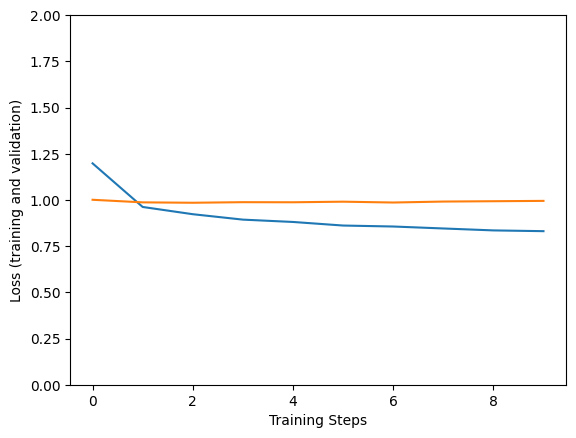

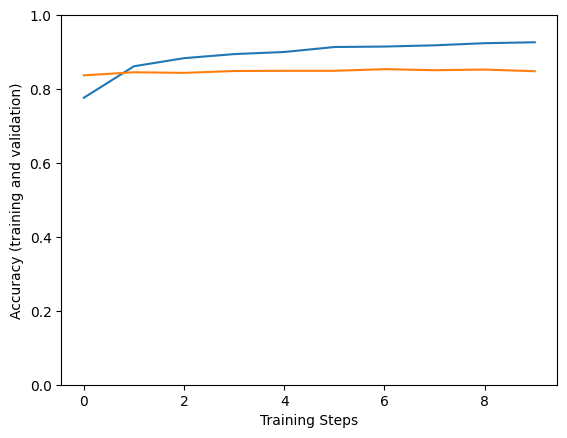

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])


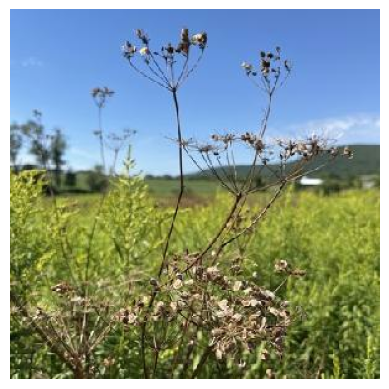

True label: wildParsnip
Predicted label: wildParsnip


In [ ]:
x, y = next(iter(val_ds))
#select next image
image = x[0, :, :, :]
#get the image index and show
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
#largest predicted label
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])


In [ ]:
saved_model_path = f"/tmp/poisonplantModel"
tf.saved_model.save(model, saved_model_path)

2023-02-12 13:38:59.306291: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/poisonplantModel/assets


INFO:tensorflow:Assets written to: /tmp/poisonplantModel/assets


In [ ]:
optimize_lite_model = True
num_calibration_examples = 60 
representative_dataset = None
if optimize_lite_model and num_calibration_examples:

  # TFLiteConverter expects a list of input tensors, each with batch size 1.
  representative_dataset = lambda: itertools.islice(
      ([image[None, ...]] for batch, _ in train_ds for image in batch),
      num_calibration_examples)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
if optimize_lite_model:
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  if representative_dataset:  # This is optional, see above.
    converter.representative_dataset = representative_dataset
lite_model_content = converter.convert()

with open(f"/tmp/lite_poisonplantModel.tflite", "wb") as f:
  f.write(lite_model_content)
print("Wrote %sTFLite model of %d bytes." %
      ("optimized " if optimize_lite_model else "", len(lite_model_content)))


2023-02-12 13:39:41.074352: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2023-02-12 13:39:41.074392: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2023-02-12 13:39:41.075095: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/poisonplantModel
2023-02-12 13:39:41.086397: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2023-02-12 13:39:41.086424: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/poisonplantModel
2023-02-12 13:39:41.132946: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2023-02-12 13:39:41.881863: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/poisonplantModel
2023-02-12 13:39:42.296665: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: O

Wrote optimized TFLite model of 22351008 bytes.


fully_quantize: 0, inference_type: 6, input_inference_type: 0, output_inference_type: 0


In [ ]:
interpreter = tf.lite.Interpreter(model_content=lite_model_content)

def lite_model(images):
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], images)
  interpreter.invoke()
  return interpreter.get_tensor(interpreter.get_output_details()[0]['index'])

In [ ]:
num_eval_examples = 50 
eval_dataset = ((image, label)  # TFLite expects batch size 1.
                for batch in train_ds
                for (image, label) in zip(*batch))
count = 0
count_lite_tf_agree = 0
count_lite_correct = 0
for image, label in eval_dataset:
  probs_lite = lite_model(image[None, ...])[0]
  probs_tf = model(image[None, ...]).numpy()[0]
  y_lite = np.argmax(probs_lite)
  y_tf = np.argmax(probs_tf)
  y_true = np.argmax(label)
  count +=1
  if y_lite == y_tf: count_lite_tf_agree += 1
  if y_lite == y_true: count_lite_correct += 1
  if count >= num_eval_examples: break
print("TFLite model agrees with original model on %d of %d examples (%g%%)." %
      (count_lite_tf_agree, count, 100.0 * count_lite_tf_agree / count))
print("TFLite model is accurate on %d of %d examples (%g%%)." %
      (count_lite_correct, count, 100.0 * count_lite_correct / count))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


TFLite model agrees with original model on 49 of 50 examples (98%).
TFLite model is accurate on 46 of 50 examples (92%).
